In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm
from autograd import grad 
import matplotlib.pyplot as plt
import scipy.stats as stats

In [7]:
def d_poly__d_x(x, t, period=1000):
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1
    
    return all_scale*(a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1) 

def d2_poly__d_x2(x, t, period=1000):
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1
    
    return all_scale*(a6*30*x**4 + a5*20*x**3 + a4*12*x**2 + a3*6*x + a2*2) 

In [3]:
def euler_maruyama_EM(X0, dt, epsilon, U_prime, num_steps, num_trajectories, dW):

    if num_trajectories == 1:
        X = np.zeros(num_steps + 1)
    else:
        X = np.zeros((num_steps + 1, num_trajectories))
    
    X[0] = X0
    
    for n in range(num_steps):

        t = n * dt
        drift = -U_prime(X[n], t)
        
        X[n+1] = X[n]  + drift * dt + np.sqrt(epsilon) * dW[n]
    
    return X

In [8]:
def drift_implicit_update(
    x_n,                 # current state X_n
    t_n,                 # current time t_n
    dt,                  # time step Delta t
    sqrt_epsilon,        # sqrt(eps) (diffusion scale)
    dW_n,                # sample from N(0, dt) for the Wiener increment
    d_poly__d_x,         # your function U'(x, t)
    max_iter=20,         # max Newton iterations
    tol=1e-10,           # convergence tolerance
    use_num_deriv=True   # whether to approximate derivative numerically
):

    # 1) Define the “target” A_n = X_n + sqrt(eps)*dW_n
    A_n = x_n + sqrt_epsilon * dW_n
    t_next = t_n + dt

    # 2) Define F(x) = x + dt*U'(x, t_{n+1}) - A_n
    def F(x):
        return x + dt * d_poly__d_x(x, t_next) - A_n

    # if use_num_deriv:
    #     # We'll do a numerical derivative for F'(x) using a small shift h
    #     def dF(x):
    #         h = 1e-8
    #         return (F(x + h) - F(x)) / h
    # else:
    #     # If you had an analytic second derivative U''(x,t),
    #     # you could do: F'(x) = 1 + dt*U''(x, t_next).
    #     # But for simplicity, we keep a numeric approach or you can add your own.
    #     def dF(x):
    #         h = 1e-8
    #         return (F(x + h) - F(x)) / h

    def dF(x):
        return 1 + d2_poly__d_x2(x, t_next) * dt

    # 3) Newton iteration
    # A decent initial guess is the explicit-Euler step:
    #   x_0 = x_n - dt * U'(x_n, t_n) + sqrt(eps)*dW_n
    # or just x_n
    x_new = x_n

    for _ in range(max_iter):
        f_val = F(x_new)
        df_val = dF(x_new)
        if abs(df_val) < 1e-15:
            # Avoid dividing by zero; break or degrade gracefully
            break
        # Newton update
        step = f_val / df_val
        x_new_next = x_new - step

        # Check for convergence
        if abs(step) < tol:
            x_new = x_new_next
            break

        x_new = x_new_next

    return x_new, t_next

In [9]:
# Parameters
X0 = 0              
dt = 0.01             # time step
T_total = 10000       # total simulation time
epsilon = 0.5         # noise strength
N = 1000              # number of trajectories to simulate per candidate F0
num_steps = int(T_total / dt)

dW = np.sqrt(dt) * np.random.randn(num_steps+1,)

sqrt_epsilon = np.sqrt(epsilon)

X_vals = np.zeros(num_steps+1)
t_vals = np.zeros(num_steps+1)

X_vals[0] = X0

for n in range(num_steps):
    # draw Wiener increment
    # drift-implicit step
    X_next, t_next = drift_implicit_update(
        x_n = X_vals[n],
        t_n = t_vals[n],
        dt = dt,
        sqrt_epsilon = sqrt_epsilon,
        dW_n = dW[n],
        d_poly__d_x = d_poly__d_x
    )
    X_vals[n+1] = X_next
    t_vals[n+1] = t_next


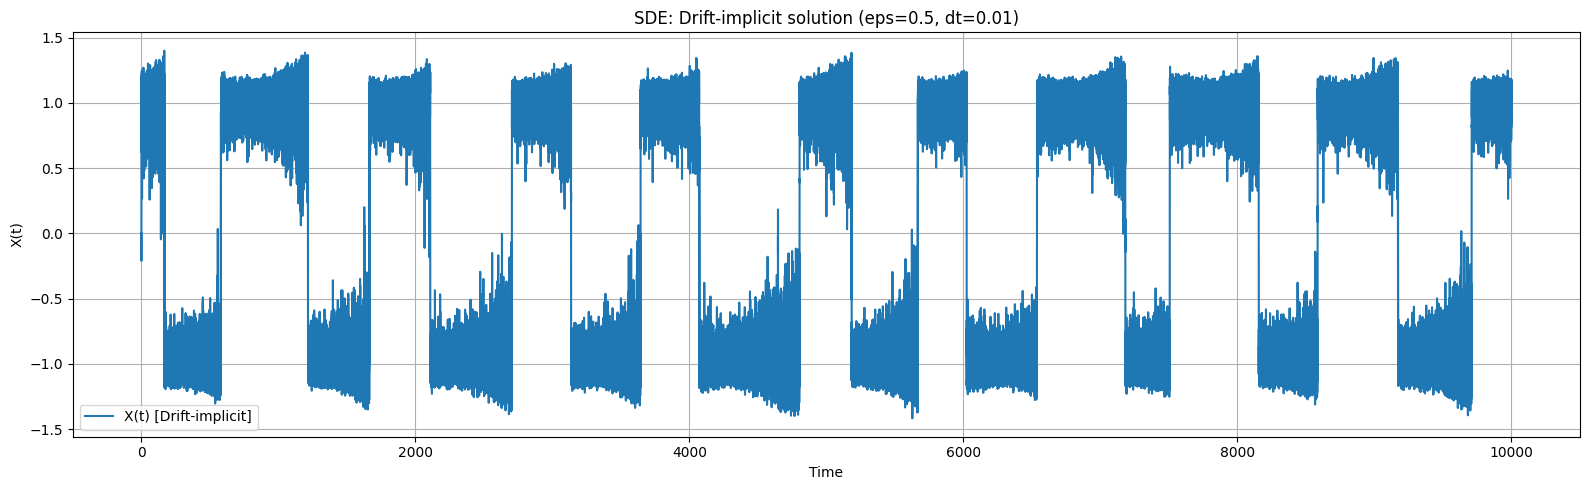

In [12]:
plt.figure(figsize=(16,5))
plt.plot(t_vals, X_vals, label="X(t) [Drift-implicit]")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.title(f"SDE: Drift-implicit solution (eps={epsilon}, dt={dt})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()